In [1]:
### Load libraries
import numpy as np
from functools import reduce
import scipy
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('notebook')
import h5py
import allel
import scipy.spatial
# set size of the labels to be more visible
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

In [2]:
# load datas
ace = allel.read_vcf('Aceee.recode.vcf', region='2R:3483099-3497400')
samples = pd.read_csv('samples.meta.txt', sep='\t')

In [3]:
# get positions
var = list(ace['variants/POS'])
# find total number of variants position
len(var)

5763

In [4]:
#https://doi.org/10.1371/journal.pgen.1009253.s003
var.index(3492074)

4233

In [5]:
### get the genotype and store it as string
mut_g280s = list(ace['calldata/GT'][4233])
mut = [l.tolist() for l in mut_g280s]
mut_allel = []
for l in mut:
    x = int("".join(map(str, l)))
    mut_allel.append(x)
# code the genotypes as SS for sensibles, RR resistant and RS for heterozygote resistant
for n, i in enumerate(mut_allel):
    if i == 0:
        mut_allel[n] = 'SS'
    elif i == 11:
        mut_allel[n] = 'RR'
    else:
        mut_allel[n] = 'RS'

In [6]:
# load samples code
s = list(ace['samples'])
# load population code
pop = list(samples.population)
# construct a data table
df = pd.DataFrame(list(zip(pop, s, mut_allel)),
                      columns=['Populations', 'Individuals', 'mut_G280S'])

<Figure size 1280x720 with 0 Axes>

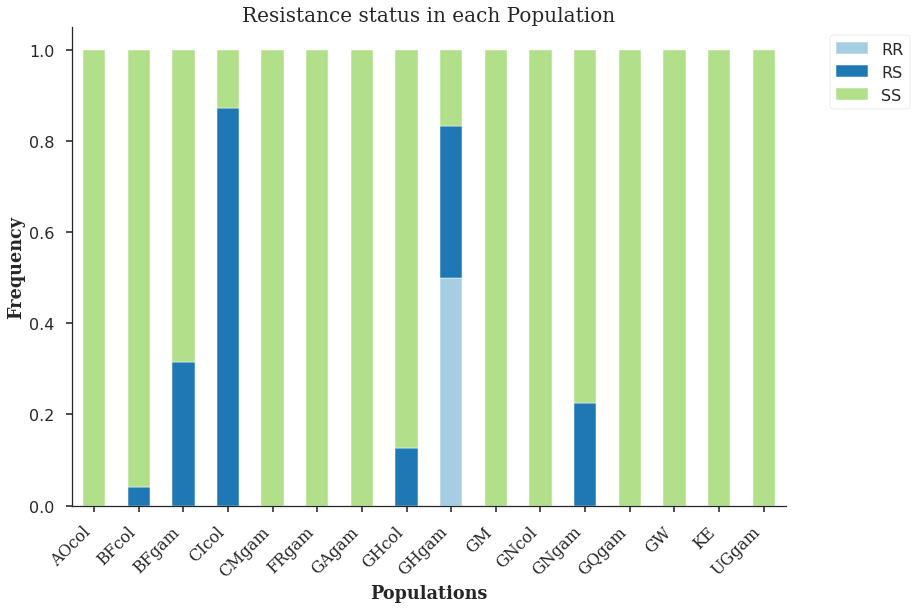

In [ ]:
# stack barplot showing the resistance status
c = sns.set_palette(sns.color_palette("Paired"))
plt.style.use(['seaborn-poster'])
plt.figure(figsize=(16,9), dpi= 80)

df1 = df.groupby('Populations')['mut_G280S'].value_counts(normalize=True).unstack('mut_G280S').plot.bar(stacked=True)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('Frequency', fontfamily='serif')
plt.xlabel('Populations', fontfamily='serif')
plt.title('Resistance status in each Population', fontsize=20, fontfamily='serif')
plt.xticks(rotation=45, horizontalalignment='right', fontfamily='serif')
sns.despine(right=True, top=True)
plt.show()

In [13]:
# construct a tuple saving the genotype data at three different indices and save the
# data as a genotypearray-like
data = (ace['calldata/GT'][4232], ace['calldata/GT'][4233], ace['calldata/GT'][4234])
g1 = allel.GenotypeArray(data)

In [14]:
# Transform each genotype call into the number of non-reference alleles 
# and use the fill argument to change how missing calls are represented (-1)
gna = g1.to_n_alt(fill=-1)
calldata = ace['calldata/GT']
g = allel.GenotypeArray(calldata)
gnb = g.to_n_alt(fill=-1)

In [16]:
#find the pairwise disance bettween gna instances and the bigdatasets in gnb
cd = allel.rogers_huff_r_between(gna, gnb)

In [17]:
# create 5763 numbers as we have 5763 mut positions
n = []
start, end = 1, 5763
if start < end: 
    # unpack the result 
    n.extend(range(start, end)) 
    # Append the last value 
    n.append(end) 
# get LD distance between g280s_mut and other mutations
cd[1]
nn = list(cd[1])

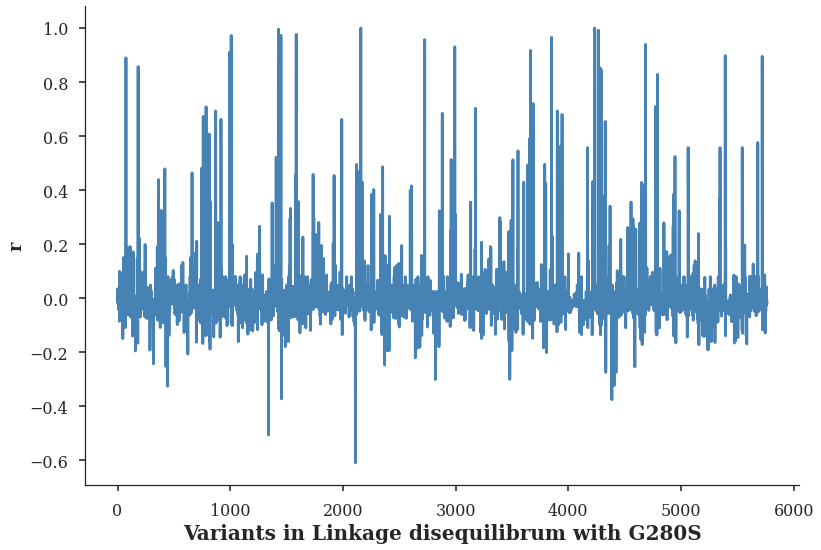

In [18]:
### plot LD between 3492074 position g280s_mut and other positions
plt.plot(n,nn, color='steelblue')
plt.ylabel('r', fontfamily='serif')
plt.xlabel("Variants in Linkage disequilibrum with G280S", fontsize=20, fontfamily='serif')
plt.xticks(horizontalalignment='center', fontfamily='serif')
plt.yticks(horizontalalignment='right', fontfamily='serif')
sns.despine(right=True, top=True)
plt.show()

In [20]:
# save in a list all LD statistics between g280s_mut and others
nf = cd[1]
# save all positions were r2 >= 0.4
indices = [i for i,v in enumerate(nf >= 0.4) if v]
# get the positions for each indices
variants = []
for i in indices:
    variant = str(ace['variants/POS'][i])
    variants.append(variant)
#to be used as input in R to find wheter
string = '2R:'
my_new_list = [string + x for x in variants]